In [1]:
import os
from glob import glob
import copy
import itertools


import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
from collections import defaultdict

%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.dates as mdates

from smrt import make_model, make_snowpack, make_ice_column, make_interface, make_emmodel, sensor_list
from smrt.core.fresnel import fresnel_coefficients, brewster_angle
from smrt.core.layer import layer_properties
from smrt.core.globalconstants import FREEZING_POINT


from smrt.emmodel.symsce_torquato21 import derived_SymSCETK21
from smrt.permittivity.snow_mixing_formula import wetsnow_permittivity_memls, wetsnow_permittivity_hallikainen86

from esa_4d_antarctica.modeling import GoodSnowpacks, depth, frequency_colors, \
                                    total_liquid_water, prepare_wet_snowpacks, \
                                    prepare_saturated_snowpacks, smos_amsr2, lband_adjusted_snowpack

runner=None

In [2]:
sites = ['aws11', 'aws5', 'amery', 'shackleton', 'aws19', 'aws15', 'aws17',
       'wilkins']

(-20.0, 0.0)

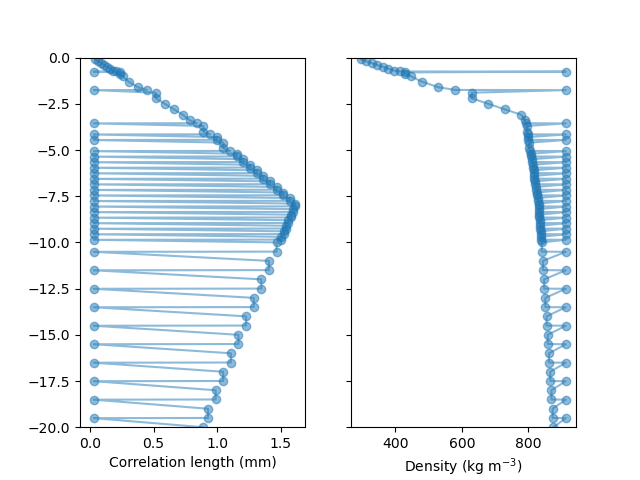

In [3]:

location = "aws19"

site0 = GoodSnowpacks(location, "winter", version=31)

season = 'winter'

f, axs = plt.subplots(1, 2, sharey=True)
z = -np.array(depth)

best_params = site0.best_params
# best 
sp = site0.prepare_best_snowpack()
axs[0].plot([l.microstructure.corr_length * 1000 for l in sp.layers], -sp.layer_depths, '-o', alpha=0.5)

axs[1].plot(sp.layer_densities[:-1], -sp.layer_depths[:-1], '-o', alpha=0.5)

axs[0].set_xlabel("Correlation length (mm)")
axs[1].set_xlabel("Density (kg m$^{-3}$)")

axs[0].set_ylim((-20, 0))

In [4]:
def run_simulations(snowpacks, model=None, **kwargs):

    if model is None:
        model = m

    res_l = model.run(smos, lband_adjusted_snowpack(snowpacks), parallel_computation=True, runner=runner, **kwargs).to_dataframe()
    return res_l
    

# Experiment 1 - Sensitivity to TWC. Wet layer of 20 cm.

In [5]:
               
smos = sensor_list.smos()

drysp = site0.prepare_best_snowpack(season_temperature=273)

dort = "dort"

wet_mixing = 'MEMLS'
if wet_mixing == 'base':
    m = make_model("symsce_torquato21",
                   dort, rtsolver_options=dict(prune_deep_snowpack=5, error_handling='nan'))
    m64 = make_model("symsce_torquato21",
                   dort, rtsolver_options=dict(prune_deep_snowpack=5, error_handling='nan', n_max_stream=64))
elif wet_mixing == 'MEMLS':
    m = make_model(derived_SymSCETK21(wetsnow_permittivity_memls),
                   dort, rtsolver_options=dict(prune_deep_snowpack=5, error_handling='nan'))
    m64 = make_model(derived_SymSCETK21(wetsnow_permittivity_memls),
                   dort, rtsolver_options=dict(prune_deep_snowpack=5, error_handling='nan', n_max_stream=64))
    
elif wet_mixing == 'H86':
    # the formulation of H86 has no absorption for liquid water =0 (it was not designed for that)
    # Because of this, we have to add the ice absorption.
    @layer_properties("density", "liquid_water")
    def permittivity_H86(frequency, density, liquid_water):
        eps = wetsnow_permittivity_hallikainen86(frequency, density, liquid_water)
        epsM = wetsnow_permittivity_memls(frequency, FREEZING_POINT, density, liquid_water=0)
        assert eps.imag >= 0
        return epsM.real + 1j * (eps.imag + epsM.imag)
    
    m = make_model(derived_SymSCETK21(permittivity_H86),
                           dort, rtsolver_options=dict(prune_deep_snowpack=5, error_handling='nan',
                                                     n_max_stream=128))
else:
    raise Exception("unknown wet snow mixing formula")


filename = f"LWCSensitivityData-Original/results-smos-{location}-experiment1-{wet_mixing}.csv"

coef = 2
twc = list(coef*np.linspace(0.0, 0.2, 20, endpoint=False)) + \
        list(coef*np.linspace(0.2, 1, 10, endpoint=False)) + \
        list(coef*np.linspace(1, 5, 10, endpoint=False)) + \
        list(coef*np.linspace(5, 20, 10))
        #list(coef*np.linspace(20, 50, 10))

snowpacks = [prepare_wet_snowpacks(drysp, 0.0, 0.30, total_liquid_water=twc_) for twc_ in twc]


if not os.path.exists(filename):
    lwc = list(map(total_liquid_water, snowpacks))
    f_liquid = [sp.layers[0].liquid_water for sp in snowpacks]
    assert np.allclose(lwc, twc)
    print('run')

    
    presult = run_simulations(snowpacks, snowpack_dimension=('twc', twc), model=m64)
    
    presult.to_csv(filename)
else:
    presult = pd.read_csv(filename).set_index('twc')


/tmp/ipykernel_341611/3563250711.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(tb.columns)


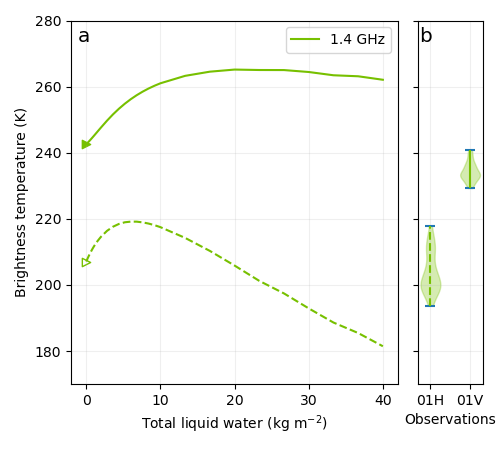

In [6]:
f, axs = plt.subplots(1, 2, sharey=True,
                      figsize=(5, 4.5), gridspec_kw=dict(width_ratios=[5, 1])) #, sharex=True)
#axs = [axs]

axs[0].plot(twc, presult['01V'], color=frequency_colors['01'], label=f'1.4 GHz')
axs[0].plot(twc, presult['01H'], '--', color=frequency_colors['01'])
        
axs[0].scatter(-0.07, presult['01V'].iloc[0], marker='>', color=frequency_colors['01'])
axs[0].scatter(-0.07, presult['01H'].iloc[0], marker='>', color='#ffffff80', edgecolor=frequency_colors['01'])

axs[0].grid(alpha=0.2)
        
axs[0].set_xlabel("Total liquid water (kg m$^{-2}$)")

axs[0].set_ylabel("Brightness temperature (K)")
#axs[1].axes.yaxis.set_ticklabels([])
axs[0].legend()


#axs[0].set_xlim((-0.2, 1.5))
axs[0].set_ylim((170, 280))

# violin plots
tb = pd.read_csv(f"DreamData/tb-melt-distribution-aws19.csv").set_index('time')
tb = tb[['01H', '01V']]
parts = axs[1].violinplot(tb.interpolate());

colors = []
for body, ch in zip(parts['bodies'], tb.columns):
    color = frequency_colors[ch[0:2]]
    body.set_facecolor(color)
    body.set_edgecolor(color)
    colors.append(color)
parts['cbars'].set_edgecolor(colors)
parts['cbars'].set_linestyle(['-' if ch[2] == 'V' else '--' for ch in tb.columns])
    
axs[1].set_xticklabels(tb.columns)
axs[1].set_xticks(range(1, len(tb.columns) + 1))
axs[1].set_xlabel("Observations")
axs[1].grid(alpha=0.2)

titles = 'ab'
for i in [0, 1]:
    axs[i].annotate(titles[i], xy=(0.02, 0.94), fontsize='x-large', xycoords=('axes fraction', 'axes fraction'))


plt.tight_layout()
plt.savefig(f"fig-smos-{location}-{season}-{wet_mixing}-experiment1.pdf")

# Experiment 3 - Depth sensitivity (Ensemble run). 

In [7]:


drysps = site0.prepare_good_snowpacks(size=1, season_temperature=273, as_dataframe=True)
drysps['drysp'] = drysps.index


fixed_twc = 6.5  # kg/m2

filename = f"LWCSensitivityData-Original/results-smos-{location}-set100-experiment3.csv"
filename0 = f"LWCSensitivityData-Original/results-smos-{location}-0-set100-experiment3.csv"

depths = list(np.linspace(0, 20, 50, endpoint=False)) #+ list(np.linspace(20, 50, 30, endpoint=False))

snowpacks = drysps.join(pd.DataFrame({"depth": depths}), how='cross')
snowpacks = snowpacks.rename(columns={'snowpack': 'dry_snowpack'})
snowpacks['snowpack'] = [prepare_wet_snowpacks(row.dry_snowpack,
                                         0.0 + row.depth,
                                         0.30 + row.depth,
                                         total_liquid_water=fixed_twc) for i, row in snowpacks.iterrows()]

if not os.path.exists(filename):

    print('run')

    presult_depth = run_simulations(snowpacks, model=m64)

    presult0 = run_simulations(drysps)

    # remove some columns before saving
    del presult_depth['dry_snowpack']
    presult_depth.to_csv(filename)
    presult0.to_csv(filename0)
else:
    presult_depth = pd.read_csv(filename)
    presult0 = pd.read_csv(filename0)

presult_depth = presult_depth.set_index(['depth', 'drysp'])
snowpacks = snowpacks.set_index(['depth', 'drysp'])

In [9]:
def weighted_mean(x):
    return pd.Series({c: np.average(x[c], weights=x.weight / np.sum(x.weight), axis=0) for c in x.columns})
        
presult_depth = presult_depth.groupby("depth").apply(weighted_mean)
presult0 = weighted_mean(presult0)

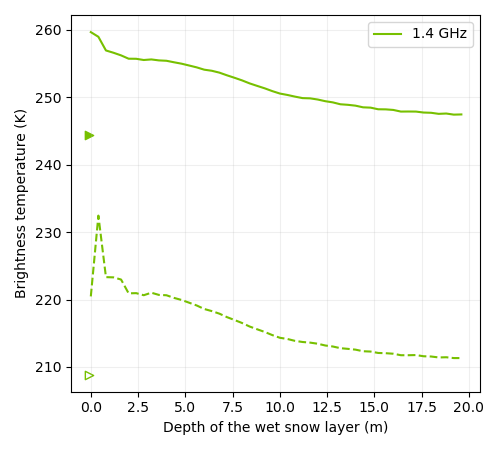

In [10]:
f, axs = plt.subplots(1, 1, figsize=(5, 4.5))
axs = [axs]

axs[0].plot(depths, presult_depth['01V'], '-', color=frequency_colors['01'], label=f'1.4 GHz')
axs[0].plot(depths, presult_depth['01H'], '--', color=frequency_colors['01']) #, label=f'AMSR2 {ch}')

axs[0].scatter(-0.07, presult0['01V'], marker='>', color=frequency_colors['01'])
axs[0].scatter(-0.07, presult0['01H'], marker='>', color='#ffffff80', edgecolor=frequency_colors['01'])

axs[0].grid(alpha=0.2)
for i in [0]:
    axs[i].legend()
    axs[i].set_xlabel("Depth of the wet snow layer (m)")
axs[0].set_ylabel("Brightness temperature (K)")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig('fig-smos-aws19-experiment3.pdf')

